# Udacity SDCND Project 5 - Vehicle Tracking 
#### Alistair Kirk - April 20 2017

In [1]:
#Init Libraries
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
% matplotlib inline
import glob

import time

In [2]:
# Create a pandas dataframe of training data
datapath = 'object-detection-crowdai/'
df_files = pd.read_csv(datapath+'labels.csv', header = 0) # Import crowdai training data
df_vehicle = df_files[(df_files['Label']=='Car')|(df_files['Label']=='Truck')].reset_index() # Merge car and truck data
df_vehicle = df_vehicle.drop('index', 1) # Removing redundant index column
df_vehicle['File_Path'] = datapath+df_vehicle['Frame'] # Adding filepath
df_vehicle = df_vehicle.drop('Preview URL',1) # Removing URL
df_vehicle.head() # Preview data frame
#df_vehicle.tail()

,xmin,ymin,xmax,ymax,Frame,Label,File_Path
0,785,533,905,644,1479498371963069978.jpg,Car,object-detection-crowdai/1479498371963069978.jpg
1,89,551,291,680,1479498371963069978.jpg,Car,object-detection-crowdai/1479498371963069978.jpg
2,268,546,383,650,1479498371963069978.jpg,Car,object-detection-crowdai/1479498371963069978.jpg
3,455,522,548,615,1479498371963069978.jpg,Truck,object-detection-crowdai/1479498371963069978.jpg
4,548,522,625,605,1479498371963069978.jpg,Truck,object-detection-crowdai/1479498371963069978.jpg


(400, 480, 3)


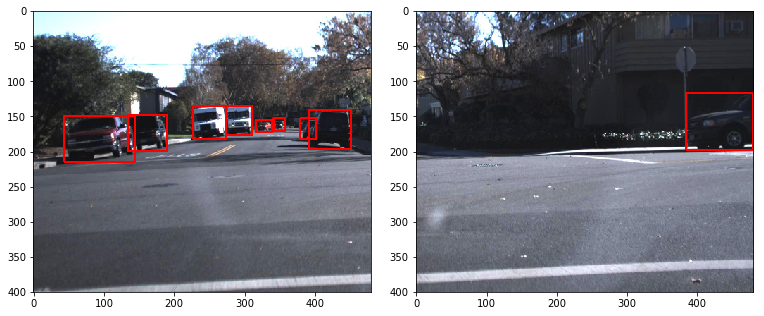

In [3]:
# Define functions to get images and bounding boxes

def plot_bboxes(imagelist,bboxlist):
        numimages = len(imagelist)
        f, axes = plt.subplots(1, numimages, figsize=(10, 5))
        f.tight_layout()
#ax1.imshow(img)
#ax1.set_title('Original Image', fontsize=50)
#ax2.imshow(undistorted)
#ax2.set_title('Undistorted Image', fontsize=50)

        for i in range(numimages):
            #print(image.shape)    
            #plt.figure(figsize=(20,10))
            #print(bboxes[0])
            for bboxes_i in bboxlist[i]:
                #print(bboxes_i)
                if (len(bboxes_i)>0):
                    cv2.rectangle(images[i],(bboxes_i[1],bboxes_i[3]),(bboxes_i[0],bboxes_i[2]),(255,0,0),thickness=2)      
            #plt.imshow(images[i])                   
            #plt.figure()
            axes[i].imshow(images[i])
        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

def get_bbox(df, ind, xsplit = 4, scale = 1, ylow = 0.125, yfrac = 2/3):
    #Get image at index
    assert type(xsplit) is int, "Need a whole integer to define a split"
    file_name = df['File_Path'][ind]
    img = cv2.imread(file_name)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    img_size = np.shape(img)
    img = cv2.resize(img,(int(scale*img_size[1]), int(scale*img_size[0])), interpolation = cv2.INTER_CUBIC)
    img_size = np.shape(img)
    #print(img_size)
    images = []
    #Find and collect the bounding boxes for this image
    main_bboxes = df[df['Frame'] == ((file_name.split('/'))[-1])].reset_index()
    #main_bboxes.head()
    #print(main_bboxes)
    bboxes = []
    for i in range(xsplit):
        #crop_img = img[200:400, 100:300] # Crop from x, y, w, h -> 100, 200, 300, 400
        # NOTE: its img[y: y + h, x: x + w]
        img_slice = img[int(img_size[0]*(1-(yfrac+ylow))):int(img_size[0]*(1-ylow)),
                            int(i*img_size[1]/xsplit):int((i*img_size[1]/xsplit)+img_size[1]/xsplit)]        
        images.append(img_slice)
        bboxes_i = []
        #find and split bounding boxes if required
        for ibox in range(len(main_bboxes)):
            # Gather the original coordinates and reset y origin depending on the fractions
            xmin = main_bboxes.iloc[ibox]['xmin']*scale
            ymin = main_bboxes.iloc[ibox]['ymin']*scale
            ymin = ymin-(int(img_size[0]*(1-(yfrac+ylow))))
            xmax = main_bboxes.iloc[ibox]['xmax']*scale
            ymax = main_bboxes.iloc[ibox]['ymax']*scale
            ymax = ymax - int(img_size[0]*(1-(yfrac+ylow)))
            
            #Start chopping boxes and add to bboxes
            width = int(img_size[1]/xsplit)
            xstart = int(i*img_size[1]/xsplit)
            #xmin = min(xmin+xstart, xstart+width)
            #xmax = min(xmax+xstart, xstart+width)
            #ymin = min(ymin, int(img_size[0]*(1-(yfrac+ylow))))
            #ymax = min(ymax, int(img_size[0]*(1-ylow)))
            if ((xmin<(xstart+width))&(xmin>xstart)):
                #print(xmin, xstart)
                xmin = min(xmin-xstart, xstart+width)
                xmax = min(xmax-xstart-1, xstart+width-1)
                bboxes_i.append([int(xmin),int(xmax),int(ymin),int(ymax)])
            if (xmin<=xstart)&(xmax>(xstart)):
                xmin = 1
                xmax = xmax-xstart
                bboxes_i.append([int(xmin),int(xmax),int(ymin),int(ymax)])
        bboxes.append(bboxes_i) 
    return images,bboxes

images,bboxlist = get_bbox(df_vehicle,1, xsplit=2, scale=0.5)
print(images[0].shape)
#print(bboxes)
plot_bboxes(images,bboxlist)


#### Masking Function

Performing Masking Test and Plotting:
(400, 480, 1)


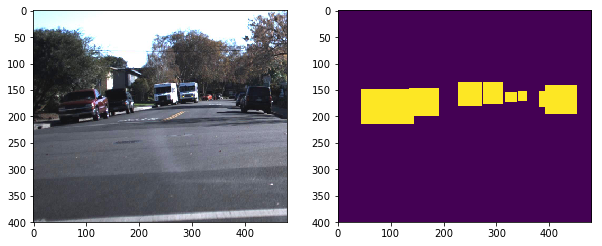

In [4]:
def get_mask(image,bboxes):
    #print(image.shape)
    #Assume you are passing in an image, and the list of bounding boxes; bboxes
    #Generate a 1 layer mask image using the bounding boxes
    mask = np.zeros_like(image[:,:,0])
    for box in bboxes:                
        mask[box[2]:box[3],box[0]:box[1]]= 1.
    mask = np.reshape(mask,(np.shape(mask)[0],np.shape(mask)[1],1))
    #print(mask.shape)
    return mask

print("Performing Masking Test and Plotting:")
images,bboxlist = get_bbox(df_vehicle,1, xsplit=2, scale=0.5)
testmask = get_mask(images[0],bboxlist[0])
print(testmask.shape)
f, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(images[0])
axes[1].imshow(np.array(testmask,dtype=np.uint8)[:,:,0])

#### AssembleTraining Data for Reuse

In [5]:
import pickle
from tqdm import tqdm #library for the progress bar during for loop
from sys import getsizeof

all_images = []
all_masks = []

data_save_loc = 'D:/cardata'

total_vehicles = len(df_vehicle)
num_train = 100 #total_vehicles
xsplit = 2
scale = 0.5

print("Splitting, Scaling, Masking {} Training Images:".format(num_train))

for i in tqdm(range(num_train)):    
    index = i
    #Randomly select the number of images, make sure to comment out if all are needed
    index = np.random.randint(total_vehicles)
    images,bboxlist = get_bbox(df_vehicle,index, xsplit=xsplit, scale=scale)
    for j in range(len(images)):
        # Create the masks, and add them to the big lists (order matters to pair img/mask!)
        jmask = get_mask(images[j],bboxlist[j])
        all_images.append(images[j])
        all_masks.append(jmask)
        #np.save(data_save_loc + '/images/'+ str(i)+'.npy',images[j])
        #np.save(data_save_loc + '/masks/'+ str(i)+'.npy', jmask)

print("Number of Training Images: {} \nNumber of Masks: {}".format(len(all_images),len(all_masks)))

# test = np.load(data_save_loc + '/images/'+ str(0)+'.npy')
# test.shape
# plt.imshow(test)

#calib_pickle = {"vehicle_images": all_images, "vehicle_masks": all_masks}
#pickle.dump( calib_pickle, open( "my_vehicle_pickle.p", "wb" ) )  
#print("Images in Memory (MB): {}".format(getsizeof(all_images)/1024/1024))
#print("Masks in Memory (MB): {}".format(getsizeof(all_masks)/1024/1024))

Splitting, Scaling, Masking 100 Training Images:


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 23.01it/s]


Number of Training Images: 200 
Number of Masks: 200


#### Create Generators to load images and mask data

In [6]:
# # Allocate 20% as a reserve for testing
# test_reserve = 0.2

# def generator_train_batch(images, masks,batch_size = 32):
#     # Expects all images and masks of the same x,y shape, matching order
#     #batch_images = []
#     #batch_masks = []
#     batch_images = np.zeros((batch_size, images[0].shape[0], images[0].shape[1], 3))
#     batch_masks = np.zeros((batch_size, images[0].shape[0], images[0].shape[1], 1))
#     while 1:
#         for i in range(batch_size):
#             j = np.random.randint(int(len(images)*(1-test_reserve)))
#             #batch_images.append(images[j])
#             #batch_masks.append(masks[j])
#             batch_images[i] = images[j]
#             batch_masks[i] = masks[j]
        
#         yield batch_images, batch_masks

# def generator_test_batch(images, masks,batch_size = 32):
#     # Expects all images and masks of the same x,y shape, matching order
#     batch_images = np.zeros((batch_size, images[0].shape[0], images[0].shape[1], 3))
#     batch_masks = np.zeros((batch_size, images[0].shape[0], images[0].shape[1], 1))
#     while 1:
#         for j in range(batch_size):
#             k = np.random.randint(int(len(images)*(test_reserve)))
#             k = k+len(images)-int(len(images)*(test_reserve))
#             batch_images[j] = images[k]
#             batch_masks[j] = masks[k]
#         yield batch_images, batch_masks

In [7]:
# gentestnum = 5
# training_gen = generator_train_batch(all_images,all_masks,gentestnum)
# batch_img,batch_mask = next(training_gen)
# print(batch_mask[0].shape)
# print(batch_img[0].shape)

#### Testing Generators

In [8]:
# ### Plotting generator output
# for i in range(gentestnum):
#     im = np.array(batch_img[i],dtype=np.uint8)
#     im_mask = np.array(batch_mask[i],dtype=np.uint8)
#     plt.subplot(1,3,1)
#     plt.imshow(im)
#     plt.axis('off')
#     plt.subplot(1,3,2)
#     plt.imshow(im_mask[:,:,0])
#     plt.axis('off')
#     plt.subplot(1,3,3)
#     plt.imshow(cv2.bitwise_and(im,im,mask=im_mask));
#     plt.axis('off')
#     plt.show();

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

#Split off 20% validation data from the newly augmented test data.
X_train, X_test, y_train, y_test = train_test_split(all_images, all_masks, test_size=0.2, random_state=42)

# Shuffle the training data
X_train, y_train = shuffle(X_train, y_train)

X_train = np.asarray(X_train)
y_train = np.asarray(y_train)
X_test = np.asarray(X_test)
y_test = np.asarray(y_test)
(X_train[0]).shape


(400, 480, 3)

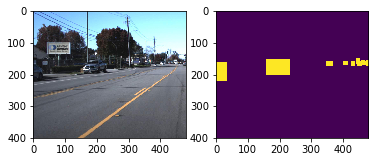

In [10]:
# Test to make sure image and mask look good
plt.subplot(1,2,1)
plt.imshow(X_test[2])

plt.subplot(1,2,2)
plt.imshow(y_test[2][:,:,0])


#### Define Neural Network
#### Credit to https://github.com/jocicmarko/ultrasound-nerve-segmentation.git and Vivek Yadav

In [11]:
from keras.models import Model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, UpSampling2D
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras import backend as K
    
def unet(imrows,imcols):
    inputs = Input((imrows, imcols,3))

    conv1 = Conv2D(8, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(8, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(16, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(16, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(32, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([UpSampling2D(size=(2, 2))(conv5), conv4], axis=3)
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([UpSampling2D(size=(2, 2))(conv6), conv3], axis=3)
    conv7 = Conv2D(32, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([UpSampling2D(size=(2, 2))(conv7), conv2], axis=3)
    conv8 = Conv2D(16, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(16, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([UpSampling2D(size=(2, 2))(conv8), conv1], axis=3)
    conv9 = Conv2D(8, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(8, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    model = Model(inputs=inputs, outputs=conv10)
    
    return model

Using TensorFlow backend.


#### Define Loss Function as Sorensen Dice Intersection

In [12]:
### Dice coeff calculation
### https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient for explanation

def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    
    return 2*(intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

#### Compile Model

In [13]:
imrows = (all_images[0].shape)[0]
imcols = (all_images[0].shape)[1]
model = unet(imrows, imcols)
model.compile(optimizer=Adam(lr=1e-4), 
              loss=dice_coef_loss, metrics=[dice_coef])

In [ ]:
model.summary()

#### Train Model - Run All Up to Here To Initialize

In [ ]:
load_pretrained = True
if load_pretrained == True:
     model.load_weights("unet_marathon.h5")

In [ ]:
def imgen():
    
    return

In [ ]:
# Create Two Generators: one for image and one for masks, then feed it the set of images and masks and train 
from keras.preprocessing.image import ImageDataGenerator
import time

BATCH_SIZE = 8
EPOCHS = 2

# we create two instances with the same arguments
data_gen_args = dict(featurewise_center=False,
                     featurewise_std_normalization=False,
                     rotation_range=15.,
                     width_shift_range=0.1,
                     height_shift_range=0.1,
                     zoom_range=0.2)
image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

# Provide the same seed and keyword arguments to the fit and flow methods
seed = 42
image_datagen.fit(X_train, augment=True, seed=seed)
mask_datagen.fit(y_train, augment=True, seed=seed)

valid_imgen = ImageDataGenerator(**data_gen_args)
valid_maskgen = ImageDataGenerator(**data_gen_args)

image_generator = image_datagen.flow(X_train, batch_size = BATCH_SIZE)
mask_generator = mask_datagen.flow(y_train, batch_size = BATCH_SIZE)

valid_im_generator = valid_imgen.flow(X_test, batch_size = BATCH_SIZE)
valid_mask_generator = valid_maskgen.flow(y_test, batch_size = BATCH_SIZE)

# combine generators into one which yields image and masks
train_generator = zip(image_generator, mask_generator)
valid_generator = zip(valid_im_generator,valid_mask_generator)

# Create a checkpoint
ckptfilepath="weights-improvement-{epoch:02d}-{val_loss:.3f}.h5"
model_checkpoint = ModelCheckpoint(ckptfilepath, monitor='val_loss', verbose=1, save_best_only=True)

import sys
t = time.time()
sys.stdout = open('my_keras_output.txt', 'w')
print("Starting time: ",time.ctime())
history = model.fit_generator(
    train_generator,
    steps_per_epoch=2,#len(X_train),
    epochs=EPOCHS,
    validation_data=valid_generator,
    validation_steps=len(X_test),
    callbacks=[model_checkpoint])
print(history.history)
print("walltime: ", time.time()-t)
sys.stdout = sys.__stdout__

#### Save Model

In [ ]:
### Save model and weights

model.save('model_ASK.h5')
model.save_weights("model_weights_ASK.h5", overwrite=True)

#### Testing Model - Run From Here to Test

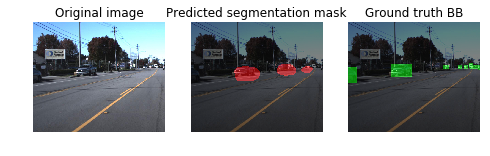

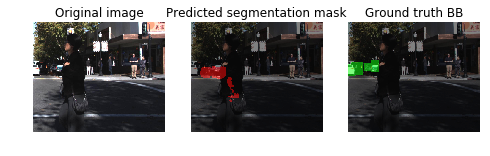

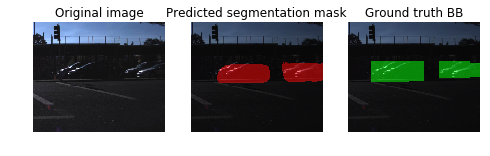

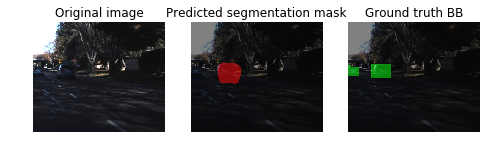

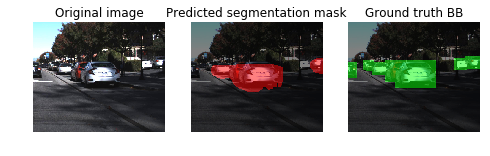

In [14]:
from keras.models import load_model
from keras.models import Model
from keras.optimizers import Adam

reload_model=False
if (reload_model):
    model = load_model('model_ASK.h5')
reload_weights=True
if (reload_weights):
    model.load_weights("model_weights_ASK.h5")
    model.compile(optimizer=Adam(lr=1e-4), loss=dice_coef_loss, metrics=[dice_coef])
    
gentestnum = 5
batch_img = []
batch_mask = []
pred_all=[]

for i in range(gentestnum):
    i_ = np.random.randint(len(X_test))
    batch_img.append(X_test[i_])
    batch_mask.append(y_test[i_])
    _predimg = np.reshape(batch_img[-1],(1,batch_img[-1].shape[0],batch_img[-1].shape[1],batch_img[-1].shape[2]))
    pred_all.append(model.predict(_predimg)[0,:,:,:])

for i in range(gentestnum):
    #i = np.random.randint(len(batch_img))
    im = np.array(batch_img[i],dtype=np.uint8)
    im_mask = np.array(255*batch_mask[i],dtype=np.uint8)
    im_pred = np.array(255*pred_all[i],dtype=np.uint8)
    
    rgb_mask_pred = cv2.cvtColor(im_pred,cv2.COLOR_GRAY2RGB)
    rgb_mask_pred[:,:,1:3] = 0*rgb_mask_pred[:,:,1:2]
    rgb_mask_true= cv2.cvtColor(im_mask,cv2.COLOR_GRAY2RGB)
    rgb_mask_true[:,:,0] = 0*rgb_mask_true[:,:,0]
    rgb_mask_true[:,:,2] = 0*rgb_mask_true[:,:,2]
    
    img_pred = cv2.addWeighted(rgb_mask_pred,0.5,im,0.5,0)
    img_true = cv2.addWeighted(rgb_mask_true,0.5,im,0.5,0)
    
    plt.figure(figsize=(8,3))
    plt.subplot(1,3,1)
    plt.imshow(im)
    plt.title('Original image')
    plt.axis('off')
    plt.subplot(1,3,2)
    plt.imshow(img_pred)
    plt.title('Predicted segmentation mask')
    plt.axis('off')
    plt.subplot(1,3,3)
    plt.imshow(img_true)
    plt.title('Ground truth BB')
    plt.axis('off')
    plt.show()

#### Define a Vehicle Class

In [15]:
# Define a class to receive the characteristics of each line detection
class Car():
    def refresh(self):        
        while (len(self.recent_box) > self.n):
            self.recent_box.pop(0)                                     
        self.bestbox = np.mean(self.recent_box, axis=0,dtype=int)        
    
    def __init__(self):
        # car detected countdown
        self.detected = 0 
        # box values of the last n predictions
        # Define as (xl,yl,xr,yr)
        self.recent_box = [] 
        #average box values of the fitted line over the last n iterations
        self.bestbox = None
        #center-point for plotting
        self.center = None        
        # Number of iterations n to remember
        self.n = 40


(-0.5, 479.5, 399.5, -0.5)

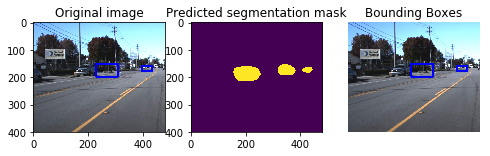

In [22]:
def lum_correct(img):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    imcopy = img.copy()
    lab= cv2.cvtColor(imcopy, cv2.COLOR_RGB2LAB)
    l,a,b = cv2.split(lab)

    cl1 = clahe.apply(l)
    equ = cv2.merge((cl1,a,b))
    final = cv2.cvtColor(equ, cv2.COLOR_LAB2RGB)
    #cl1 = clahe.apply(np.array(img, dtype=np.uint8)[:,:,0])
    #equ = cv2.equalizeHist(cl1)
    #res = np.hstack((img,final)) #stacking images side-by-side
    #print(final.shape)
    #plt.imshow(res)
    return final

def pred_heatmap(img):    
    #print(img.shape)
    _predimg = np.reshape(img,(1,img.shape[0],img.shape[1],img.shape[2]))
    pred = model.predict(_predimg)[0,:,:,:]
    pred = np.array(pred, dtype=np.uint8)
    #plt.imshow(pred[:,:,0])
    return pred

def label_find(img):
    img = img[:,:,0]
    from scipy.ndimage.measurements import label
    labels,num_features = label(img)
    labels = label(img)
    #print("Uniques: ",labels[1])
    #plt.imshow(labels[0], cmap='gray')
    return labels

# Modified from Udacity SDCND Course:
def get_bboxes(labels):
    # Define a minimum detection threshold in pixels:
    boxthresh = 400
    #imcopy = img.copy()
    bbox = []
    # Iterate through all detected cars
    
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        if (np.count_nonzero(nonzero)>boxthresh):
            #print("Size of nonzero:",np.count_nonzero(nonzero))
            # Identify x and y values of those pixels
            nonzeroy = np.array(nonzero[0])
            nonzerox = np.array(nonzero[1])
            # Define Margin to correct for NN offset
            margintop = 0.02
            marginleft = 0.02   
            # Define a bounding box based on min/max x and y
            xl = int(np.min(nonzerox)*(1-marginleft))
            yl = int(np.min(nonzeroy)*(1-margintop))
            xr = int(np.max(nonzerox)*(1-marginleft))
            yr = int(np.max(nonzeroy)*(1-margintop))

            bbox.append([xl,yl,xr,yr])        
        # Draw the box on the image
        #cv2.rectangle(imcopy, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return bbox

def cardistance(center1,center2):
    from scipy.spatial import distance
    dst = distance.euclidean(center1,center2)
    return dst

def carinbox(newbox, bestbox):
    if (newbox[0]>bestbox[0]) & (newbox[2]<bestbox[2]) & (newbox[1]>bestbox[1]) & (newbox[3]<bestbox[3]):
        print("found in box")
        return True
    else:
        return False

def draw_bboxes(image, CarList, bbox):
    #Establish proximity for car boxes in pixels:
    carthresh = 150
    # Establish how many frames a car should last:
    car_countdown = 3
    
    for box in bbox:
        centerxy = (int(0.5*(box[2] + box[0])),int(0.5*(box[3] + box[1])))
        #print(centerxy)
        #img = cv2.circle(img, centerxy, 5, (255,0,0), 6)
        if len(CarList)==0:
            #print("firstcar")
            carnew = Car()
            carnew.detected = car_countdown
            carnew.center = centerxy
            carnew.recent_box.append(box)
            carnew.refresh()
            CarList.append(carnew)
        else:
            isnewcar = False;
            for car in CarList:
                # If the new car center is within an existing center, merge cars
                if (cardistance(car.center,centerxy)<carthresh):
                    car.center = centerxy
                    car.recent_box.append(box)
                    car.detected = car_countdown
                    car.refresh()                    
                else:
                    isnewcar = True
            if (isnewcar):
                carnew = Car()
                carnew.detected = car_countdown
                carnew.center = centerxy
                carnew.recent_box.append(box)
                carnew.refresh()
                CarList.append(carnew)
                
    #print(len(CarList))
    #print(bbox[0])
    img_boxed = image.copy()
    for ind1, car in enumerate(CarList):    
        car.detected = car.detected - 1
        if (car.detected<=0):
            #print("removing")
            CarList.remove(car)
        else:
            for ind2, othercar in enumerate(CarList):
                if carinbox(othercar.bestbox, car.bestbox)&(ind1!=ind2):
                    CarList.remove(othercar)
            for ind2, othercar in enumerate(CarList):
                #Compare centers, and not to itself                
                if (cardistance(othercar.center,car.center)<carthresh)&(ind1!=ind2):
                    car.recent_box = car.recent_box + othercar.recent_box
                    car.bestbox = np.mean(car.recent_box, axis=0,dtype=int)
                    CarList.remove(othercar)
            #img = cv2.circle(img, car.center, 5, (255,0,0), 6)
            # Draw the box on the image
            #print(car.bestbox)
            bbox1 = (car.bestbox[0],car.bestbox[1])
            bbox2 = (car.bestbox[2],car.bestbox[3])
            img_boxed = cv2.rectangle(image, bbox1, bbox2, (0,0,255), 6)
    return img_boxed

img = X_test[2].copy()

img_pred = pred_heatmap(lum_correct(img))
labels = label_find(img_pred)

CarList = []
bbox = get_bboxes(labels)
img_boxed = draw_bboxes(img,CarList,bbox)

plt.figure(figsize=(8,3))
plt.subplot(1,3,1)
plt.imshow(img)
plt.title('Original image')
plt.axis('on')
plt.subplot(1,3,2)
plt.imshow(img_pred[:,:,0])
plt.title('Predicted segmentation mask')
plt.axis('on')
plt.subplot(1,3,3)
plt.imshow(img_boxed)
plt.title('Bounding Boxes')
plt.axis('off')


#### Process Pipeline

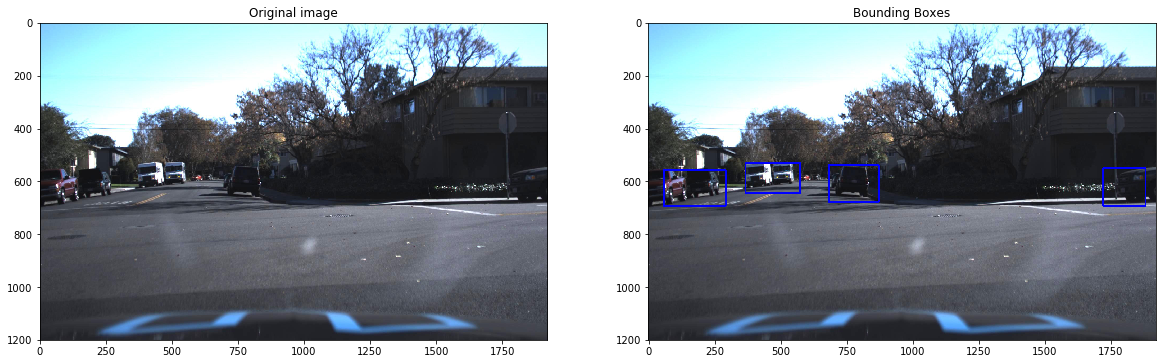

In [17]:
def bbox_pipeline(image):
    #print(image.shape)
    image = cv2.resize(image,(1920,1200),interpolation = cv2.INTER_CUBIC)
    #print("Orig Size:",image.shape)
    orig_image = image.copy()
    xsplit = 2
    scale = 0.5
    ylow = 0.125
    yfrac = 2/3
    images = []
    img_size = np.shape(image)
    
    image = cv2.resize(image,(int(scale*img_size[1]), int(scale*img_size[0])), interpolation = cv2.INTER_CUBIC)
    img_size = np.shape(image)
    for i in range(xsplit):
        img_slice = image[int(img_size[0]*(1-(yfrac+ylow))):int(img_size[0]*(1-ylow)),
                            int(i*img_size[1]/xsplit):int((i*img_size[1]/xsplit)+img_size[1]/xsplit)]
        images.append(img_slice)
    
    img_pred = np.hstack((pred_heatmap(lum_correct(images[0])),pred_heatmap(lum_correct(images[1]))))
    
    #print(img_size)
    # top, bottom, left, right - border width in number of pixels in corresponding directions
    top = int(img_size[0]*(1-(yfrac+ylow)))
    bottom =  int(img_size[0]*ylow)
    #print("borderb4:",img_pred.shape)
    img_pred = cv2.copyMakeBorder(img_pred,top,bottom,0,0,cv2.BORDER_CONSTANT,value=0)
    #print("borderafter:",img_pred.shape)
    img_size = np.shape(img_pred)
    #print("img_size_prescale",img_size)
    img_pred = cv2.resize(img_pred,(int((1/scale)*img_size[1]), int((1/scale)*img_size[0])), interpolation = cv2.INTER_CUBIC)
    img_pred = np.reshape(img_pred,(img_pred.shape[0],img_pred.shape[1],1))
    
    #print("scaledpred:",img_pred.shape)
    #rgbmask = np.array(255*img_pred,dtype=np.uint8)
    #rgb_mask_pred = cv2.cvtColor(rgbmask,cv2.COLOR_GRAY2RGB)
    #plt.imshow(rgb_mask_pred)
    #plt.figure()
    #rgb_mask_pred[:,:,1:3] = 0*rgb_mask_pred[:,:,1:2]
    
    #print('fullsize',img_pred.shape)
    labels = label_find(img_pred)
    bbox = get_bboxes(labels)
    #print("labzero",labels[0].shape)
    #img_boxed = draw_labeled_bboxes(orig_image,labels)
    img_boxed = draw_bboxes(orig_image,CarList,bbox)
    
    #print("rgbmaskshp",rgb_mask_pred.shape)
    #print("boxedshape:",img_boxed.shape)
    #img_boxed = cv2.addWeighted(rgb_mask_pred,0.5,img_boxed,0.5,0)
    
    return img_boxed

file_name = df_vehicle['File_Path'][10]
test_pipeline = cv2.cvtColor(cv2.imread(file_name),cv2.COLOR_BGR2RGB)

CarList = []

plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(test_pipeline)
plt.title('Original image')
plt.subplot(1,2,2)
plt.imshow(bbox_pipeline(test_pipeline))
plt.title('Bounding Boxes')



#### Process Movie

In [ ]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

CarList = []

white_output = 'my_test.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(bbox_pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video my_test.mp4
[MoviePy] Writing video my_test.mp4



 11%|████████▌                                                                      | 137/1261 [00:13<02:14,  8.35it/s]

found in box



 19%|██████████████▉                                                                | 239/1261 [00:25<01:54,  8.93it/s]

found in box
found in box



 19%|███████████████▏                                                               | 243/1261 [00:25<02:04,  8.15it/s]

found in box



 22%|█████████████████▏                                                             | 275/1261 [00:29<01:48,  9.12it/s]

found in box



 23%|█████████████████▊                                                             | 285/1261 [00:30<01:52,  8.70it/s]

found in box



 23%|█████████████████▉                                                             | 286/1261 [00:30<01:58,  8.26it/s]

found in box



 23%|██████████████████                                                             | 289/1261 [00:30<01:53,  8.53it/s]

found in box



 24%|██████████████████▉                                                            | 303/1261 [00:32<01:50,  8.63it/s]

found in box



 26%|████████████████████▏                                                          | 323/1261 [00:34<01:43,  9.06it/s]

found in box
found in box



 26%|████████████████████▎                                                          | 324/1261 [00:34<01:47,  8.74it/s]

found in box
found in box



 26%|████████████████████▎                                                          | 325/1261 [00:34<01:52,  8.30it/s]

found in box
found in box



 26%|████████████████████▍                                                          | 326/1261 [00:35<01:52,  8.34it/s]

found in box
found in box



 27%|████████████████████▉                                                          | 335/1261 [00:36<01:44,  8.82it/s]

found in box



 27%|█████████████████████                                                          | 336/1261 [00:36<01:46,  8.71it/s]

found in box
found in box



 27%|█████████████████████                                                          | 337/1261 [00:36<01:47,  8.59it/s]

found in box



 36%|████████████████████████████▏                                                  | 450/1261 [00:48<01:29,  9.09it/s]

found in box



 36%|████████████████████████████▎                                                  | 451/1261 [00:48<01:28,  9.15it/s]

found in box



 42%|█████████████████████████████████▎                                             | 532/1261 [00:56<01:19,  9.18it/s]

found in box



 42%|█████████████████████████████████▍                                             | 534/1261 [00:57<01:23,  8.68it/s]

found in box



 42%|█████████████████████████████████▌                                             | 535/1261 [00:57<01:20,  8.97it/s]

found in box



 43%|█████████████████████████████████▌                                             | 536/1261 [00:57<01:23,  8.68it/s]

found in box



 43%|█████████████████████████████████▋                                             | 537/1261 [00:57<01:22,  8.81it/s]

found in box



 43%|█████████████████████████████████▋                                             | 538/1261 [00:57<01:24,  8.57it/s]

found in box



 43%|█████████████████████████████████▊                                             | 539/1261 [00:57<01:27,  8.28it/s]

found in box



 43%|█████████████████████████████████▊                                             | 540/1261 [00:57<01:24,  8.55it/s]

found in box



 43%|█████████████████████████████████▉                                             | 541/1261 [00:58<01:25,  8.39it/s]

found in box



 43%|█████████████████████████████████▉                                             | 542/1261 [00:58<01:28,  8.13it/s]

found in box



 43%|██████████████████████████████████▏                                            | 546/1261 [00:58<01:21,  8.72it/s]

found in box



 43%|██████████████████████████████████▎                                            | 547/1261 [00:58<01:21,  8.81it/s]

found in box



 43%|██████████████████████████████████▎                                            | 548/1261 [00:58<01:28,  8.06it/s]

found in box



 44%|██████████████████████████████████▍                                            | 549/1261 [00:58<01:28,  8.09it/s]

found in box



 44%|██████████████████████████████████▌                                            | 552/1261 [00:59<01:23,  8.45it/s]

found in box



 44%|██████████████████████████████████▋                                            | 554/1261 [00:59<01:29,  7.91it/s]

found in box



 44%|██████████████████████████████████▊                                            | 556/1261 [00:59<01:28,  7.98it/s]

found in box



 45%|███████████████████████████████████▏                                           | 562/1261 [01:00<01:19,  8.84it/s]

found in box



 46%|████████████████████████████████████▎                                          | 579/1261 [01:02<01:22,  8.26it/s]

found in box



 46%|████████████████████████████████████▍                                          | 582/1261 [01:02<01:26,  7.88it/s]

found in box



 46%|████████████████████████████████████▌                                          | 584/1261 [01:03<01:34,  7.17it/s]

found in box



 47%|████████████████████████████████████▊                                          | 587/1261 [01:03<01:29,  7.51it/s]

found in box



 47%|████████████████████████████████████▊                                          | 588/1261 [01:03<01:29,  7.51it/s]

found in box



 47%|████████████████████████████████████▉                                          | 589/1261 [01:03<01:31,  7.33it/s]

found in box



 47%|█████████████████████████████████████▍                                         | 597/1261 [01:05<01:30,  7.37it/s]

found in box



 47%|█████████████████████████████████████▍                                         | 598/1261 [01:05<01:32,  7.18it/s]

found in box



 48%|█████████████████████████████████████▋                                         | 602/1261 [01:05<01:34,  6.94it/s]

found in box



 48%|██████████████████████████████████████                                         | 608/1261 [01:06<01:23,  7.80it/s]

found in box



 48%|██████████████████████████████████████▏                                        | 609/1261 [01:06<01:27,  7.47it/s]

found in box



 49%|██████████████████████████████████████▎                                        | 612/1261 [01:07<01:23,  7.74it/s]

found in box
found in box



 50%|███████████████████████████████████████▋                                       | 633/1261 [01:09<01:09,  9.08it/s]

found in box



 50%|███████████████████████████████████████▊                                       | 636/1261 [01:09<01:09,  9.01it/s]

found in box



 51%|████████████████████████████████████████▍                                      | 645/1261 [01:10<01:10,  8.72it/s]

found in box



 56%|████████████████████████████████████████████                                   | 704/1261 [01:17<01:05,  8.47it/s]

found in box



 56%|████████████████████████████████████████████▏                                  | 706/1261 [01:17<01:09,  7.95it/s]

found in box



 56%|████████████████████████████████████████████▌                                  | 712/1261 [01:18<01:07,  8.16it/s]

found in box



 57%|████████████████████████████████████████████▉                                  | 718/1261 [01:18<01:05,  8.26it/s]

found in box



 57%|█████████████████████████████████████████████▍                                 | 725/1261 [01:19<01:00,  8.83it/s]

found in box



 61%|████████████████████████████████████████████████▏                              | 769/1261 [01:24<00:52,  9.39it/s]

found in box



 61%|████████████████████████████████████████████████▏                              | 770/1261 [01:24<00:53,  9.21it/s]

found in box



 62%|████████████████████████████████████████████████▊                              | 779/1261 [01:25<00:54,  8.79it/s]

found in box



 62%|████████████████████████████████████████████████▊                              | 780/1261 [01:25<00:54,  8.85it/s]

found in box



 62%|█████████████████████████████████████████████████                              | 783/1261 [01:26<00:53,  8.99it/s]

found in box



 62%|█████████████████████████████████████████████████▏                             | 786/1261 [01:26<00:54,  8.70it/s]

found in box



 76%|███████████████████████████████████████████████████████████▊                   | 955/1261 [01:45<00:34,  8.89it/s]

found in box



 76%|███████████████████████████████████████████████████████████▉                   | 957/1261 [01:45<00:34,  8.88it/s]

found in box



 76%|████████████████████████████████████████████████████████████                   | 959/1261 [01:45<00:33,  8.94it/s]

found in box



 76%|████████████████████████████████████████████████████████████▏                  | 960/1261 [01:45<00:33,  8.94it/s]

found in box



 78%|█████████████████████████████████████████████████████████████▌                 | 983/1261 [01:48<00:33,  8.32it/s]

found in box



 79%|██████████████████████████████████████████████████████████████▏                | 993/1261 [01:49<00:30,  8.71it/s]

found in box



 79%|██████████████████████████████████████████████████████████████▎                | 994/1261 [01:49<00:30,  8.72it/s]

found in box



 79%|██████████████████████████████████████████████████████████████▎                | 995/1261 [01:49<00:30,  8.61it/s]

found in box



 79%|██████████████████████████████████████████████████████████████▌                | 998/1261 [01:50<00:30,  8.70it/s]

found in box



 79%|██████████████████████████████████████████████████████████████▌                | 999/1261 [01:50<00:31,  8.37it/s]

found in box



 79%|█████████████████████████████████████████████████████████████▉                | 1001/1261 [01:50<00:30,  8.41it/s]

#### Display Movie

In [19]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))